<a href="https://colab.research.google.com/github/ThisIsFarhan/LangGraph-Practice/blob/main/9_ChatBot_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_groq langsmith

In [2]:
from google.colab import userdata
groq_api_key=userdata.get('groq_api_key')
langsmith=userdata.get('LANGSMITH_API_KEY')

import os
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ChatBot with Memory"

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

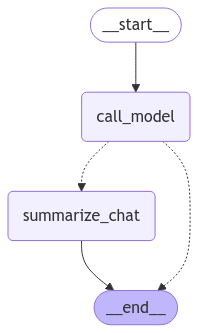

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

class State(MessagesState):
  summary:str

# Check if the summary exist
def call_model(state:State):
  summary = state.get('summary',"")
  if summary:
    system_msg = f"Summary of conversation earlier: {summary}"
    messages = [SystemMessage(content=system_msg)] + state["messages"]
  else:
    messages = state["messages"]

  response = llm.invoke(messages)
  return {"messages":response}


#Summarization Node
def summarize_chat(state:State):
  summary = state.get("summary","")
  if summary:
    summary_msg = f"This is the summary of the conversation to date: {summary}\nExtend the summary according to the messages above"
  else:
    summary_msg = "Make the summary according to the messages above"

  messages = state["messages"] + [HumanMessage(content=summary_msg)]
  response = llm.invoke(messages)

  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary":response.content,"messages":delete_messages}

#Conditional Node
def should_summarize(state:State):
  messages = state["messages"]
  if len(messages) > 6:
    return "summarize_chat"
  else:
    return END

builder = StateGraph(State)
builder.add_node(call_model,"call_model")
builder.add_node(summarize_chat,"summarize_chat")

builder.add_edge(START,"call_model")
builder.add_conditional_edges("call_model",should_summarize)
builder.add_edge("summarize_chat",END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Farhan")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Farhan! 👋 

It's nice to meet you. What can I do for you today? 😊
================================== Ai Message ==================================

Your name is Farhan!  You told me when you first introduced yourself. 😄 


Is there anything else I can help you with?
================================== Ai Message ==================================

That's awesome, Farhan!  🏈  The 49ers are a great team.  Are you excited for the season?  Who's your favorite player?  🤔


In [6]:
graph.get_state(config).values.get("summary","")

''

In [7]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You are absolutely right! Nick Bosa is a phenomenal player and he recently signed the biggest contract ever for a defensive player.  💪  What do you like most about his game?


In [8]:
input_message = HumanMessage(content="Can you help with maths questions?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I sure can! I'm pretty good at math. 

To help me best assist you, please tell me:

* **What kind of math question is it?** (e.g., algebra, calculus, geometry, arithmetic)
* **Can you write out the full question?**
* **What have you tried so far?**  

The more information you give me, the better I can understand your question and provide a helpful solution. 😊


In [9]:
input_message = HumanMessage(content="Can you help with differential calculus")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Absolutely! I can help with differential calculus.  

To get started, tell me:

* **What specific topic within differential calculus are you working on?**  (e.g., limits, derivatives, chain rule, product rule, quotient rule, related rates)
* **Do you have a particular problem you'd like help with? If so, please write it out.**
* **What have you tried so far?** 

The more context you give me, the more effectively I can guide you through the solution.  Let's tackle this together! 💪 🧮


In [10]:
input_message = HumanMessage(content="I love DE")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

That's great!  DE stands for Differential Equations, right?  

It's a fascinating field. What specifically about DEs do you enjoy?  

* Are you working on a particular type of DE right now? 
* Do you have a favorite application of DEs?
*  Is there anything specific you'd like to discuss or get help with regarding DEs? 


Let me know, and I'll do my best to engage in a meaningful conversation about them! 😊


In [11]:
graph.get_state(config).values.get("summary","")

'Farhan introduced himself and said he likes the San Francisco 49ers. He mentioned that Nick Bosa is his favorite player and knows he holds the record for the highest paid defensive player.  \n\nFarhan then asked if I could help with math questions and I confirmed that I could. He specifically requested help with differential calculus. We discussed his interest in the topic and he mentioned  he likes DE.  He clarifies that DE stands for Differential Equations and explained he enjoys learning about them. \n\n\n\n'